In [1]:
import numpy as np
from matplotlib import pyplot as plt
import random as rand
from math import floor
from time import sleep
from IPython.display import clear_output, display
from time import time

In [2]:
# helper function definitions

def check_neighbors(i, j, map_to_check, include_center):
    num_filled_neighbors = 0
    for x in range(max([0, i-1]),min([map_to_check.shape[0], i + 2])):
        for y in range(max([0, j-1]),min([map_to_check.shape[1], j + 2])):
            if map_to_check[x][y] != 0:
                num_filled_neighbors = num_filled_neighbors + 1
    if include_center == 0 and (map_to_check[i][j] != 0): num_filled_neighbors = num_filled_neighbors - 1
    
    return num_filled_neighbors

def find_max_neighbor(i, j, map_to_check): # input should be a difference map.
    max_neighbor = [[i,j]]
    for x in range(max([0, i-1]),min([map_to_check.shape[0], i + 2])):
        for y in range(max([0, j-1]),min([map_to_check.shape[1], j + 2])):
            if map_to_check[x][y] > map_to_check[max_neighbor[0][0]][max_neighbor[0][1]]:
                max_neighbor = [[x,y]]
            if map_to_check[x][y] == map_to_check[max_neighbor[0][0]][max_neighbor[0][1]]:
                max_neighbor.append([x,y])
    return rand.choice(max_neighbor)
    
    
def update_plants(plant_map):
    mask = np.zeros(plant_map.shape)
    for i in range(0,plant_map.shape[0]):
        for j in range(0,plant_map.shape[1]):
            if check_neighbors(i,j,plant_map, 1) > 0:
                mask[i][j] = 1
    plant_map = plant_map + mask
    return plant_map

def update_herbs(herb_map, plant_map, num_moves, survival_likelihood, hunger, reproduction_chance, density_limit):
    # this is re-used for updating carnivores as well
    
    # num_moves = 1
    # reproduction_chance = .5
    # death_likelihood = 4 # (higher number -> less likely to die, less likely to eat)
    excess_food_map = plant_map - herb_map
    
    # move to a better place if there is one nearby. Pick randomly if there are ties (running in circles is fun!)
    for n in range(0,num_moves):
        movement_mask = np.zeros(plant_map.shape)
        for i in range(0,herb_map.shape[0]):
            for j in range(0,herb_map.shape[1]):
                if herb_map[i][j] > plant_map[i][j]:
                    amount = herb_map[i][j] - plant_map[i][j]
                    dest = find_max_neighbor(i, j, excess_food_map)
                    movement_mask[i][j] = movement_mask[i][j] - (amount)
                    movement_mask[dest[0]][dest[1]] = movement_mask[dest[0]][dest[1]] + amount
        herb_map = herb_map + movement_mask
    
    # cull the herd. Darwin is an unforgiving master
    for i in range(0,herb_map.shape[0]):
        for j in range(0,herb_map.shape[1]):
            if herb_map[i][j] > plant_map[i][j]:
                overpopulation = int(herb_map[i][j] - plant_map[i][j])
                herb_map[i][j] = plant_map[i][j]
                for n in range(overpopulation):
                    if rand.randint(0,10) < survival_likelihood: herb_map[i][j] = herb_map[i][j] + 1
    
    # now that the culling is over, feast! Don't forget sex too.
    sex_mask = np.zeros(herb_map.shape)
    for i in range(0,herb_map.shape[0]):
        for j in range(0,herb_map.shape[1]):
            if herb_map[i][j] > 0:
                for n in range(int(floor(herb_map[i][j]/2))):
                    sex_prob = rand.randint(1,11) - 10 * (1 - reproduction_chance)
                    sex_mask[i][j] = sex_mask[i][j] + np.clip(sex_prob, 0,1)
                for n in range(int(herb_map[i][j])):
                    if rand.randint(0,10) < hunger: plant_map[i][j] = plant_map[i][j] - 1
            
            plant_map = np.clip(plant_map, 0, density_limit)
            
    herb_map = herb_map + sex_mask

    return [herb_map, plant_map]
                        
                
    # for each location,
    # if herbs > plants, the difference will move to a nearby square with less, if there is one (do this in a mask). else move randomly
    # repeat (n)x
    # if herbs > plants, kill extras
    # plants = plants - herbs
    # for each herb, if 2 or more are on a square, have a p% chance of reproducing per herb


In [12]:
# initialize the map
island_size = [20,20]
plants_start = 5
plants = np.ones(island_size) * plants_start
herbs = np.zeros(island_size)
carns = np.zeros(island_size)
plants_line = []
herbs_line = []
carns_line = []

herbs[0:4][:] = 5
carns[0][:] = 2

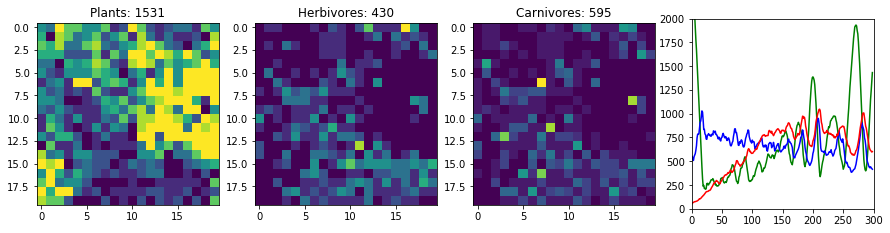

DONE


In [14]:
fig, ax_list = plt.subplots(1, 4, figsize=(15,3.5))

# update_herbs(herb_map, plant_map, num_moves, survival_likelihood, hunger, reproduction_chance, prey_density_limit):

sim_length = 300
for i in range(sim_length): # main update loop
    ax_list[0].cla()
    ax_list[1].cla()
    ax_list[2].cla()
    ax_list[3].cla()
    old_herbs = np.array([herbs])
    old_carns = np.array([carns])
    plants = update_plants(plants)
    herbs,plants = update_herbs(herbs, plants, 5, 2, 7, 0.9, 8) # Other options: [3, 2, 8, .8, 5] [1, 2, 8, .8, 5]
    carns,herbs = update_herbs(carns, herbs, 5, 6, 2, 0.2, 10) # Other options: [5, 5, 5, .4, 10] [3, 5, 5, .4, 10]
    clear_output(wait=True)
    ax_list[0].imshow(plants)
    ax_list[0].set_title("Plants: " + str(int(np.sum(plants))))
    ax_list[1].imshow(herbs)
    ax_list[1].set_title("Herbivores: " + str(int(np.sum(herbs))))
    ax_list[2].imshow(carns)
    ax_list[2].set_title("Carnivores: " + str(int(np.sum(carns))))
    ax_list[3].set_xlim(0,sim_length)
    ax_list[3].set_ylim(0,island_size[0] * island_size[1] * plants_start)
    ax_list[3].plot([x for x in plants_line], 'g')
    ax_list[3].plot(herbs_line, 'b')
    ax_list[3].plot([x for x in carns_line], 'r')
    plt.show()
    display(fig)
    
    # save the number of each population
    plants_line.append(np.sum(plants))
    herbs_line.append(np.sum(herbs))
    carns_line.append(np.sum(carns))
    
    if np.count_nonzero(np.subtract(old_herbs,np.array([herbs]))) == 0 and np.count_nonzero(np.subtract(old_carns,np.array([carns]))) == 0: break

print("DONE")